# COMP5495 Robot Learning - Project part 2

Andrea Pierré & Jonathan Eisenbies

## Initialization

In [1]:
from pathlib import Path
import ipywidgets as widgets
import h5py
import numpy as np
from movement_primitives.promp import ProMP
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import make_splrep
from tqdm.auto import tqdm
import robosuite
from door_custom import DoorCustom
import imageio
from robosuite import load_composite_controller_config

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/kir0ul/Projects/COMP5495_RobotLearning/.direnv/python-3.13/lib64/python3.13/site-packages/robosuite/scripts/setup_macros.py (macros.py:55)
[robosuite WARNING] Could not import robosuite_models. Some robots may not be available. If you want to use these robots, please install robosuite_models from source (https://github.com/ARISE-Initiative/robosuite_models) or through pip install. (__init__.py:30)
[robosuite WARNING] Could not load the mink-based whole-body IK. Make sure you install related import properly, otherwise you will not be able to use the default IK controller setting for GR1 robot. (__init__.py:40)


In [2]:
%matplotlib ipympl

## Select the data

In [3]:
data_path = Path("..")
data_path.exists()

True

In [4]:
demos_filepaths = list(data_path.glob("**/demos.h5"))
demos_filepaths

[PosixPath('../Door-Opening-v1/demos.h5'),
 PosixPath('../Door+cube/demos.h5'),
 PosixPath('../Door+cube/door_actions/clear-path_traj/demos.h5'),
 PosixPath('../Door+cube/door_actions/open-door_traj/demos.h5')]

In [5]:
selection_widget = widgets.SelectMultiple(
    options=demos_filepaths,
    value=[],
    rows=10,
    description="Data files",
    disabled=False,
    layout=widgets.Layout(width="90%"),
)
display(selection_widget)

SelectMultiple(description='Data files', layout=Layout(width='90%'), options=(PosixPath('../Door-Opening-v1/de…

In [7]:
selected_files = selection_widget.value
selected_files

(PosixPath('../Door+cube/demos.h5'),)

In [8]:
for filename in selected_files:
    if filename != "traj.h5":
        print(f"Processing: {filename}")

        with h5py.File(filename, "r") as fid:
            num_demos = len(list(fid.keys()))
            print(f"Demos in root file: {' '.join(list(fid.keys()))}")

            # Get shortest demo sizes
            for dem in range(num_demos):
                cur_size = fid[f"demo{dem + 1}"]["timestamps"].shape[0]
                if dem == 0:
                    timesteps = cur_size
                    dem_id = 1
                if cur_size < timesteps:
                    timesteps = cur_size
                    dem_id = dem + 1
            # timesteps = fid["demo1"]["timestamps"].shape[0]
            xmlFile = fid[f"demo{dem_id}"].attrs["xmlmodel"]

            stateSize = fid[f"demo{dem_id}"]["states"].shape[1]
            actionSize = fid[f"demo{dem_id}"]["actions"].shape[1]
            T = np.zeros([num_demos, timesteps])
            Y = np.zeros([num_demos, timesteps, stateSize])
            # Actions = np.zeros([num_demos, timesteps, actionSize])

            for idx in range(num_demos):
                currentDemo = idx + 1
                fileTimestamps = fid[f"demo{currentDemo}"]["timestamps"]
                T[idx] = fileTimestamps[0:timesteps]

                fileStates = fid[f"demo{currentDemo}"]["states"]
                # fileActions = fid[f"demo{currentDemo}"]["actions"]

                # for jdx in range(fileStates.shape[0]):
                Y[idx, :, :] = fileStates[0:timesteps, :]
                # Actions[idx][jdx] = fileActions[jdx]

Processing: ../Door+cube/demos.h5
Demos in root file: demo1 demo2


## Process demonstrations

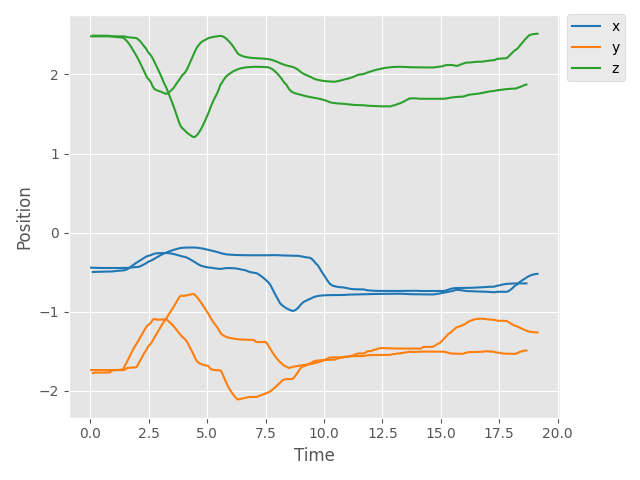

In [9]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab10").colors

    for d_i in range(num_demos):
        if d_i == 0:
            ax.plot(T[d_i, :], Y[d_i, :, 1], label="x", color=cmap[0])
            ax.plot(T[d_i, :], Y[d_i, :, 2], label="y", color=cmap[1])
            ax.plot(T[d_i, :], Y[d_i, :, 3], label="z", color=cmap[2])
        else:
            ax.plot(T[d_i], Y[d_i, :, 1], color=cmap[0])
            ax.plot(T[d_i], Y[d_i, :, 2], color=cmap[1])
            ax.plot(T[d_i], Y[d_i, :, 3], color=cmap[2])

    ax.legend(bbox_to_anchor=(1, 1.02), loc="upper left")
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    fig.tight_layout()
    plt.show()

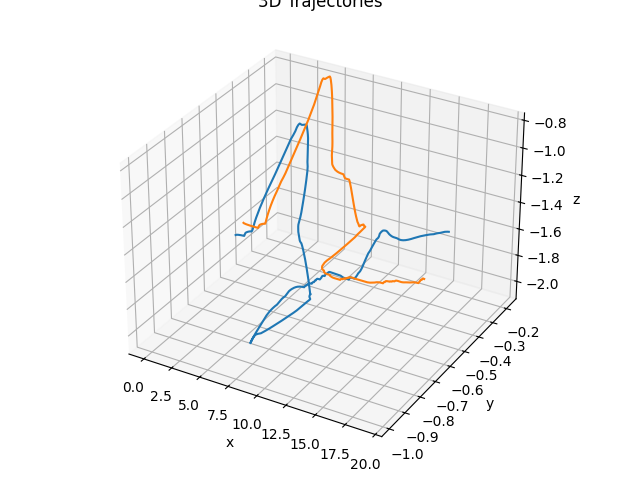

In [10]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
cmap = mpl.colormaps.get("tab10").colors

for d_i in range(num_demos):
    ax.plot(
        T[d_i],
        Y[d_i, :, 1],
        Y[d_i, :, 2],
        Y[d_i, :, 3],
        label=f"Demo {d_i + 1}",
        color=cmap[d_i],
    )

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
fig.tight_layout()
ax.set_title("3D Trajectories")
plt.show()

## Smoothing

In [11]:
nb_points = 200
smoothing = 0.001
Y_smooth = np.zeros([num_demos, nb_points, stateSize])
total_sec_interp = np.linspace(T[0, 0], T[-1, -1], nb_points)
for d_i in tqdm(range(num_demos)):
    for s_i in tqdm(range(stateSize), leave=False):
        # Y_smooth[d_i, :, 0] = make_splrep(T[:, 0], Y[d_i, :, 0], s=smoothing)(total_sec_interp)
        # Y_smooth[d_i, :, 1] =  make_splrep(T[:, 0], Y[d_i, :, 1], s=smoothing)(total_sec_interp)
        # Y_smooth[d_i, :, 2] =  make_splrep(T[:, 0], Y[d_i, :, 2], s=smoothing)(total_sec_interp)
        Y_smooth[d_i, :, s_i] = make_splrep(T[0, :], Y[d_i, :, s_i], s=smoothing)(
            total_sec_interp
        )

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

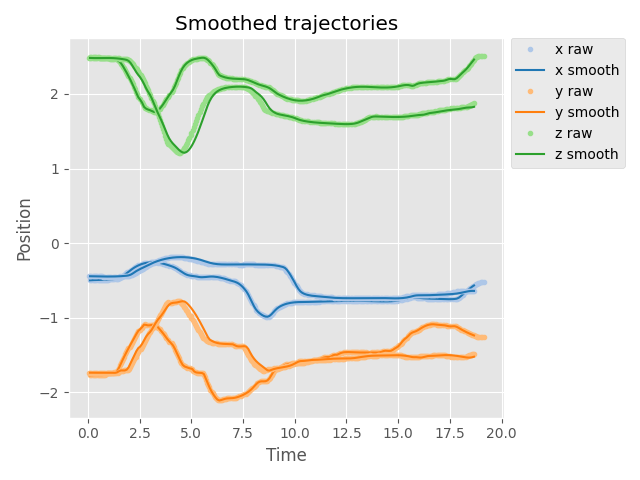

In [12]:
with plt.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab20").colors

    for d_i in range(num_demos):
        if d_i == 0:
            ax.plot(T[d_i], Y[d_i, :, 1], ".", label="x raw", color=cmap[1])
            ax.plot(
                total_sec_interp,
                Y_smooth[d_i, :, 1],
                "-",
                label="x smooth",
                color=cmap[0],
            )
            ax.plot(T[d_i], Y[d_i, :, 2], ".", label="y raw", color=cmap[3])
            ax.plot(
                total_sec_interp,
                Y_smooth[d_i, :, 2],
                "-",
                label="y smooth",
                color=cmap[2],
            )
            ax.plot(T[d_i], Y[d_i, :, 3], ".", label="z raw", color=cmap[5])
            ax.plot(
                total_sec_interp,
                Y_smooth[d_i, :, 3],
                "-",
                label="z smooth",
                color=cmap[4],
            )
        else:
            ax.plot(T[d_i], Y[d_i, :, 1], ".", color=cmap[1])
            ax.plot(total_sec_interp, Y_smooth[d_i, :, 1], "-", color=cmap[0])
            ax.plot(T[d_i], Y[d_i, :, 2], ".", color=cmap[3])
            ax.plot(total_sec_interp, Y_smooth[d_i, :, 2], "-", color=cmap[2])
            ax.plot(T[d_i], Y[d_i, :, 3], ".", color=cmap[5])
            ax.plot(total_sec_interp, Y_smooth[d_i, :, 3], "-", color=cmap[4])

    ax.legend(bbox_to_anchor=(1, 1.02), loc="upper left")
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.set_title("Smoothed trajectories")
    fig.tight_layout()
    plt.show()

## ProMP

In [13]:
T = np.empty((num_demos, nb_points))
T[:, :] = np.linspace(0.0, 1.0, nb_points)

In [14]:
n_weights = 100
# y_conditional_cov = np.array([0.025])
# T_smooth = np.tile(total_sec_interp, (3, 1))
promp = ProMP(n_dims=3, n_weights_per_dim=n_weights)
# promp.imitate(T_smooth, Y_smooth[:, :, 1:4], verbose=1)
promp.imitate(T, Y_smooth[:, :, 1:4], verbose=1)
# weights = promp.weights(T_smooth[0], Y_smooth[0, :, 1:4])
# promp.trajectory_from_weights(T_smooth[0], weights)
# Y_mean = promp.mean_trajectory(T_smooth[0])
Y_mean = promp.mean_trajectory(T[0])
# Y_conf = 1.96 * np.sqrt(promp.var_trajectory(T_smooth[0]))
Y_conf = 1.96 * np.sqrt(promp.var_trajectory(T[0]))

Iteration 0001: delta = 4.13556
Iteration 0002: delta = 19.0295
Iteration 0003: delta = 2.59717
Iteration 0004: delta = 0.0222785
Iteration 0005: delta = 0.00015156
Iteration 0006: delta = 1.96376e-06


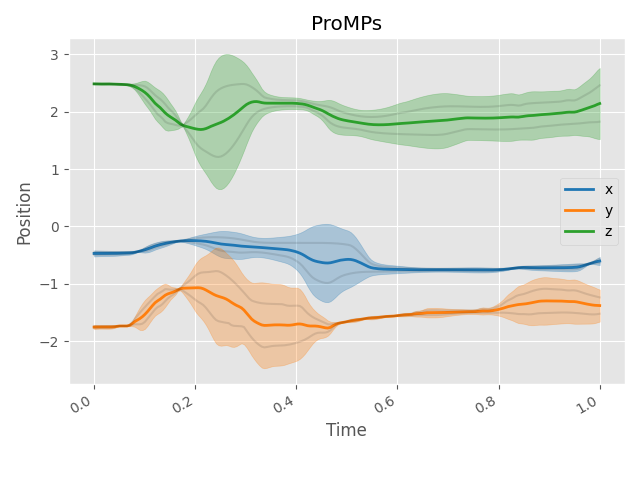

In [15]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab10").colors

    labels = ("x", "y", "z")
    for dim in range(Y_mean.shape[1]):
        label = labels[dim]
        ax.fill_between(
            # T_smooth[0, :],
            T[0, :],
            (Y_mean[:, dim] - Y_conf[:, dim]).ravel(),
            (Y_mean[:, dim] + Y_conf[:, dim]).ravel(),
            alpha=0.3,
            color=cmap[dim],
        )
        # ax.plot(T_smooth[0, :], Y_mean[:, dim], lw=2, label=label, color=cmap[dim])
        ax.plot(T[0, :], Y_mean[:, dim], lw=2, label=label, color=cmap[dim])
        for d_i in range(num_demos):
            # ax.plot(T_smooth[d_i, :], Y_smooth[d_i, :, dim + 1], c="k", alpha=0.1)
            ax.plot(T[d_i, :], Y_smooth[d_i, :, dim + 1], c="k", alpha=0.1)

    ax.legend(loc="best")
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.set_title("ProMPs")
    fig.tight_layout()
    fig.autofmt_xdate()
    plt.show()

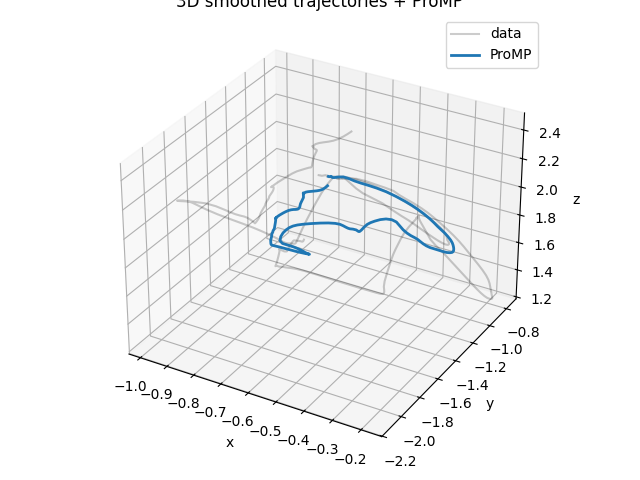

In [16]:
# with plt.style.context("ggplot"):
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
for d_i in range(num_demos):
    if d_i == 0:
        ax.plot(
            Y_smooth[d_i, :, 1],
            Y_smooth[d_i, :, 2],
            Y_smooth[d_i, :, 3],
            label="data",
            alpha=0.2,
            c="k",
        )
    else:
        ax.plot(
            Y_smooth[d_i, :, 1],
            Y_smooth[d_i, :, 2],
            Y_smooth[d_i, :, 3],
            alpha=0.2,
            c="k",
        )

ax.plot(Y_mean[:, 0], Y_mean[:, 1], Y_mean[:, 2], lw=2, label="ProMP")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
fig.tight_layout()
ax.set_title("3D smoothed trajectories + ProMP")
ax.legend(loc="best")
plt.show()

## New initial point

In [17]:
# y_conditional_cov = np.array([0])
# y_conditional_cov = np.tile([0.025], (3, 1))
y_conditional_cov = np.tile([0.0], (3, 1))
y_ini = np.array([-0.5, -2, 2])

# t_ini = 0.015
t_ini = 0.0
cpromp = promp.condition_position(
    y_mean=y_ini, y_cov=y_conditional_cov, t=t_ini, t_max=1.0
)
# Y_cmean = cpromp.mean_trajectory(T_smooth[0, :])
Y_cmean = cpromp.mean_trajectory(T[0, :])
# Y_cconf = 1.96 * np.sqrt(cpromp.var_trajectory(T_smooth[0, :]))
Y_cconf = 1.96 * np.sqrt(cpromp.var_trajectory(T[0, :]))

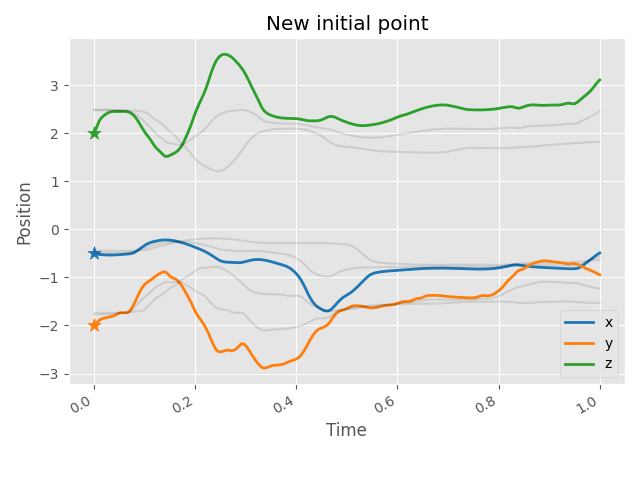

In [18]:
with mpl.style.context("ggplot"):
    fig, ax = plt.subplots()
    cmap = mpl.colormaps.get("tab10").colors

    labels = ("x", "y", "z")
    for dim in range(Y_mean.shape[1]):
        label = labels[dim]
        ax.scatter([t_ini], y_ini[dim], marker="*", s=100, color=cmap[dim])
        ax.fill_between(
            # T_smooth[0, :],
            T[0, :],
            (Y_cmean[:, dim] - Y_cconf[:, dim]).ravel(),
            (Y_cmean[:, dim] + Y_cconf[:, dim]).ravel(),
            alpha=0.3,
            color=cmap[dim],
        )
        # ax.plot(T_smooth[0, :], Y_cmean[:, dim], lw=2, label=label, color=cmap[dim])
        ax.plot(T[0, :], Y_cmean[:, dim], lw=2, label=label, color=cmap[dim])
        for d_i in range(num_demos):
            # ax.plot(T_smooth[d_i, :], Y_smooth[d_i, :, dim + 1], c="k", alpha=0.1)
            ax.plot(T[d_i, :], Y_smooth[d_i, :, dim + 1], c="k", alpha=0.1)

    ax.legend(loc="best")
    ax.set_xlabel("Time")
    ax.set_ylabel("Position")
    ax.set_title("New initial point")
    fig.tight_layout()
    fig.autofmt_xdate()
    plt.show()

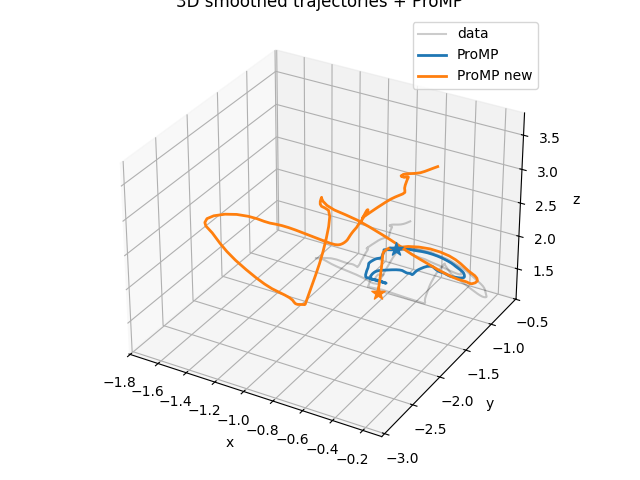

In [19]:
# with plt.style.context("ggplot"):
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
cmap = mpl.colormaps.get("tab10").colors
for d_i in range(num_demos):
    if d_i == 0:
        ax.plot(
            Y_smooth[d_i, :, 1],
            Y_smooth[d_i, :, 2],
            Y_smooth[d_i, :, 3],
            label="data",
            alpha=0.2,
            c="k",
        )
    else:
        ax.plot(
            Y_smooth[d_i, :, 1],
            Y_smooth[d_i, :, 2],
            Y_smooth[d_i, :, 3],
            alpha=0.2,
            c="k",
        )

ax.plot(Y_mean[:, 0], Y_mean[:, 1], Y_mean[:, 2], lw=2, label="ProMP", color=cmap[0])
ax.scatter(Y_mean[0, 0], Y_mean[0, 1], Y_mean[0, 2], marker="*", s=100, color=cmap[0])
ax.plot(
    Y_cmean[:, 0], Y_cmean[:, 1], Y_cmean[:, 2], lw=2, label="ProMP new", color=cmap[1]
)
ax.scatter(y_ini[0], y_ini[1], y_ini[2], marker="*", s=100, color=cmap[1])

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
fig.tight_layout()
ax.set_title("3D smoothed trajectories + ProMP")
ax.legend(loc="best")
plt.show()

## Motion reproduction on the robot

In [20]:
# # Load the desired controller config with default Basic controller
# config = load_composite_controller_config(controller="WHOLE_BODY_IK")
controller_config = load_composite_controller_config(controller="BASIC")
# config = load_composite_controller_config(controller="HYBRID_MOBILE_BASE")
# controller_config["body_parts"]["right"]["input_type"] = "absolute"
controller_config["body_parts"]["right"]["input_type"] = "delta"
controller_config["body_parts"].pop("left")
controller_config["body_parts"].pop("torso")
controller_config["body_parts"].pop("head")
controller_config["body_parts"].pop("base")
controller_config["body_parts"].pop("legs")

[robosuite INFO] Loading controller configuration from: /home/kir0ul/Projects/COMP5495_RobotLearning/.direnv/python-3.13/lib64/python3.13/site-packages/robosuite/controllers/config/default/composite/basic.json (composite_controller_factory.py:121)


{'type': 'JOINT_POSITION',
 'input_max': 1,
 'input_min': -1,
 'output_max': 0.5,
 'output_min': -0.5,
 'kd': 200,
 'kv': 200,
 'kp': 1000,
 'velocity_limits': [-1, 1],
 'kp_limits': [0, 1000],
 'interpolation': None,
 'ramp_ratio': 0.2}

In [21]:
camera_names = (
    "frontview",
    "birdview",
    "agentview",
    "sideview",
    "robot0_robotview",
    "robot0_eye_in_hand",
)
camera_name = camera_names[0]

# create environment instance
env = robosuite.make(
    # env_name="Door",
    env_name="DoorCustom",
    robots="UR5e",
    has_renderer=True,
    has_offscreen_renderer=True,
    use_camera_obs=False,
    controller_configs=controller_config,
    renderer="mjviewer",
    render_camera=camera_name,
)

In [22]:
# create a video writer with imageio
video_path = Path(".") / "video.mp4"
video_writer = imageio.get_writer(video_path, fps=24)
frames = []

# reset the environment
env.reset()

action = np.zeros_like(env.action_spec[0])
# for ite in range(T_smooth.shape[1]):
for ite in range(nb_points):
    delta_pos = Y_mean[ite, :]
    # delta_pos[0] = -Y_mean[ite, 1]
    # delta_pos[1] = Y_mean[ite, 0]
    if controller_config["body_parts"]["right"]["input_type"] == "delta":
        if ite > 0:
            delta_pos = Y_mean[ite, :] - obs["robot0_eef_pos"]
    action[0:3] = delta_pos
    # action[0:3] = Y_mean[ite, :]
    # action[6] =
    # action[0] = -Y_mean[ite, 1]

    obs, reward, done, info = env.step(action)  # take action in the environment
    # env.render()  # render on display

    video_img = env.sim.render(height=512, width=512, camera_name=camera_name)[::-1]
    video_writer.append_data(video_img)

    if done:
        break

env.viewer.close()
video_writer.close()
print(f"Video saved to {video_path}")

/home/kir0ul/Projects/COMP5495_RobotLearning/.direnv/python-3.13/lib64/python3.13/site-packages/glfw/__init__.py:917: GLFWError: (65548) b'Wayland: The platform does not provide the window position'
  warnings.warn(message, GLFWError)


Video saved to video.mp4
